# Сборный проект

Перед нами данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) 

### Цель исследования:
выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных
Name — название игры <br>
Platform — платформа <br>
Year_of_Release — год выпуска <br>
Genre — жанр игры <br>
NA_sales — продажи в Северной Америке (миллионы проданных копий) <br>
EU_sales — продажи в Европе (миллионы проданных копий) <br>
JP_sales — продажи в Японии (миллионы проданных копий) <br>
Other_sales — продажи в других странах (миллионы проданных копий) <br>
Critic_Score — оценка критиков (максимум 100) <br>
User_Score — оценка пользователей (максимум 10) <br>
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. <br>

In [34]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats as st

In [35]:
# загружаем файл в переменную
pth1 = 'games.csv'

if os.path.exists(pth1):
    games = pd.read_csv(pth1)
else:
    print('Something is wrong')
    

In [36]:
# посмотрим на данные
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [37]:
# немного статистики
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Видно, что колонки именованны некорректно. А столбец User_Score имеет не подходящий тип данных - строковый. С остальными колонками всё в порядке

### Подготовка данных

In [38]:
# переименуем столбцы так, чтобы привести их к нижнему регистру
games.columns = games.columns.str.lower()

In [39]:
# поменяем типа данных в столбце с годом выпуска на целое число
games['year_of_release'] = games['year_of_release'].astype('Int64')

In [40]:
# проверим количество пропусков в каждом столбце
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [41]:
# Т.к игр без названия мало - 2 штуки - можно смело удалять эти строки. А так же строки с пропущенным жанром и годом выпуска
games = games.dropna(subset=['name','genre','year_of_release'])

In [42]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [43]:
# пропуски в столбце с рейтингком заполним на Unknown
games['rating'] = games['rating'].fillna('Unknown')

Пропуски в столбцах critic_score, user_score  заполнять не будем, т.к это может сильно исказить статистику

В столбце user_score есть строковое значение tbd, из-за которого весь столбец принял тип данных object и над ним нельзя проводить математические операции. Заменим это значение пропуском, потому что tbd означает to be determined.

In [44]:
# заменим строковое знаечние пропуском
games.loc[games['user_score']=='tbd','user_score'] = np.nan

In [45]:
# поменяет типа данных со строкового на числовой
games['user_score'] = games['user_score'].astype('float64')

In [46]:
# посмотрим, игры с каким рейтингом присутствуют в датасете
games.groupby('rating').agg({'name':'count'}).sort_values(by='name', ascending=False)

,name
rating,
Unknown,6676
E,3921
T,2905
M,1536
E10+,1393
EC,8
K-A,3
AO,1
RP,1


In [47]:
# Т.к. игры с рейтингом EC, K-A, AO, RP встречаются крайне редко, их можно удалить
games = games.loc[games['rating'].isin(['E','T','M','E10+','Unknown'])]

In [48]:
# пропущенных значений стало меньше, а пропуски которые остались заполнять не надо - это исказит статистику
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8451
user_score         8974
rating                0
dtype: int64

In [49]:
# добавим отдельный столбец с суммарными продажами во всех регионах
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

Пропуски в в столбцах с оценами пользователей и критиков могли появится потому, что игры довольно старые и в годы их выпуска их еще не оценивали. Так же пропуски возможны у непопулярных игр, о которых мало кто знает или их еще никто не успел оценить. Пропуски в колонке name вероятно появились в результате технических причин, некорректном вводе, потере информации и тд

### Исследовательский анализ данных 

In [50]:
# посмотрим, сколько игр выпускалось каждый год
games.groupby('year_of_release')['name'].agg('count')

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     262
1997     287
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     936
2006    1006
2007    1197
2008    1427
2009    1425
2010    1251
2011    1134
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Видно, что с 1994 год бум компьютерных игр стал набирать обороты, поскольку их выпуск в два раза превысил предыдущий год. Вероятно, это связано с началом выпуска фирмой Apple Computers — Power PC. Затем развитие компьютерных игр стабильно росло, в 2006 году выпуск перевалил 1000 игр в год. Однако, в 2012 году произошел резкий спад, количество новинок снизилось почти в 2 раза, и после этого стало падать. В 2016 году было выпущено 502 игры, чуть больше, чем в 2001 году. 

#### Важны ли данные за все периоды?

Т.к. технологии стремительно меняются, а наша цель - спланировать рекламные компании, и нам нужны актуальные данные. Поэтому дальше будем рассматривать только последние 4 года продаж. Для этого создадим новый столбец. Он принимает значение "1" для игр, которые вышли позже 2011 года

<div class="alert alert-success"> 
<h2> Комментарий ревьюера VERS#2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
 Действительно, для анализа нужно выбрать последние годы и посмотреть какие из платформ продаются на текущий момент, чтобы строить какие-то прогнозы на 2017 год. Поэтому следует отбросить старые ожившие тренды и не учитывать пиковые значения прошлых лет, так как эти данные в большей части соответсвуют платформам, не работающим к текущему моменту, а также могут значительно исказить оценку новых зарождающих трендов. За актуальный лучше выделять период не ранее с 2012 года, что будет соответствовать ориентировочно году начала работы действующих платформ, чей пик приходится на последние года (2014-2015). Хотелось бы отметить, что в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал - иначе обязательно захватишь уже отжившие тренды. Но и слишком короткий период тоже не стоит брать.

In [51]:
games['recent_years'] = (games['year_of_release'] > 2011) * 1

#### Как менялись продажи по платформам ?

In [52]:
games.groupby(['platform']).agg({'total_sales':'sum'}).sort_values(['total_sales'], ascending=False).head(10)

,total_sales
platform,
PS2,1233.32
X360,961.24
PS3,931.34
Wii,890.52
DS,802.13
PS,725.67
PS4,314.14
GBA,312.88
PSP,289.53


Подробнее посмотрим на продажи каждой из платформ

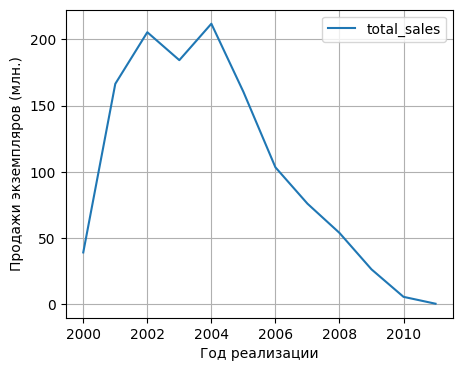

In [53]:
ax = games.loc[games['platform'] == 'PS2'].groupby(['year_of_release']).agg({'total_sales':'sum'}).plot(figsize=(5,4),grid=True)
# меняем наименование горизонтальной линии ('X')
plt.xlabel('Год реализации')
# меняем наименование вертикальной линии ('Y')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

PS2 была на пике популярности в начале нулевых, однако к 2010 году продаж игр снизились почти до нуля

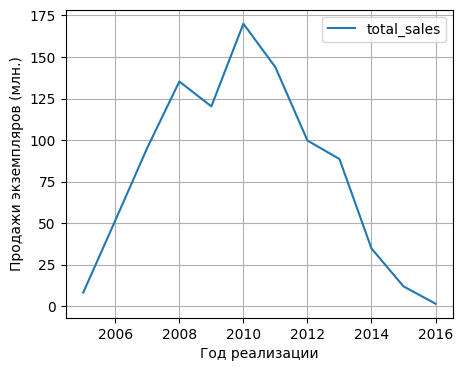

In [54]:
ax = games.loc[games['platform'] == 'X360'].groupby(['year_of_release'])\
        .agg({'total_sales':'sum'}).plot(figsize=(5,4),grid=True)
# меняем наименование горизонтальной линии ('X')
plt.xlabel('Год реализации')
# меняем наименование вертикальной линии ('Y')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

X360 был крайне популярным в 2010 году, достигнув почти 160 млн продаж по всему миру, однако к 2016 году игры на эту консоль почти перестали продаваться

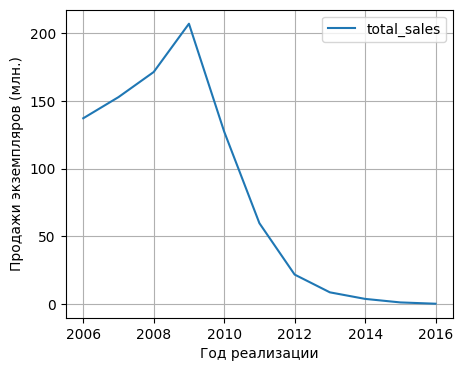

In [55]:
ax = games.loc[games['platform'] == 'Wii'].groupby(['year_of_release']).agg({'total_sales':'sum'}).plot(figsize=(5,4),grid=True)
# меняем наименование горизонтальной линии ('X')
plt.xlabel('Год реализации')
# меняем наименование вертикальной линии ('Y')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Более 175 млн игр продали для Wii в 2009 году, но к 2016 году в нее перестали играть

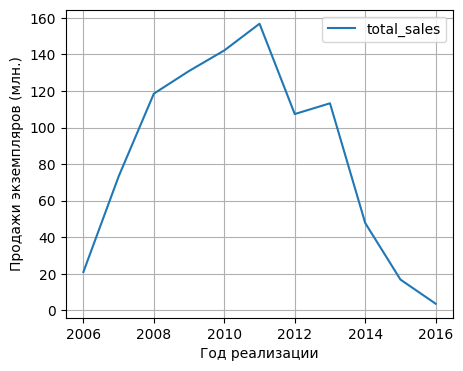

In [56]:
ax = games.loc[games['platform'] == 'PS3'].groupby(['year_of_release']).agg({'total_sales':'sum'}).plot(figsize=(5,4),grid=True)
# меняем наименование горизонтальной линии ('X')
plt.xlabel('Год реализации')
# меняем наименование вертикальной линии ('Y')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Самыми популярными консолями за все годы были PS2, X360, Wii, PS3, DS, PS. Каждая из этих консолей уверенно держалась на рынке примерно по 10 лет. Однако, к 2016 году они перестали быть востребованными, поэтому отсеим игры, вышедшие до 2011 года. Для этого сгруппируемся по полю recent_years для дальнейшего исследования

In [57]:
games.groupby(['recent_years','platform']).agg({'total_sales':'sum'})\
    .sort_values(['recent_years','total_sales'], ascending=False).head(15)

total_sales
recent_years platform             
1            PS4            314.14
             PS3            288.79
             X360           236.54
             3DS            194.61
             XOne           159.32
             WiiU            82.19
             PC              62.65
             PSV             49.18
             Wii             35.37
             DS              12.55
             PSP             11.19
0            PS2           1233.32
             Wii            855.15
             DS             789.58
             PS             725.67

Видно, что приставки с наибольшим количеством игр, которые мы выделели в прошлом пункте, были популярны в годах, которые нас мало интересуют в рамках исследования. Поэтому выделим наиболее популярные приставки за недавнее время, среди них 
PS4, PS3, X360, 3DS, XOne, WiiU, PС

In [58]:
# посмотрим только на 2016 год
games.loc[games['year_of_release']==2016].groupby(['recent_years','platform']).agg({'total_sales':'sum'}).sort_values(['recent_years','total_sales'], ascending=False).head(15)

total_sales
recent_years platform             
1            PS4             69.25
             XOne            26.15
             3DS             15.14
             PC               5.25
             WiiU             4.60
             PSV              4.25
             PS3              3.60
             X360             1.52
             Wii              0.18

Если смотреть на данные только за прошлй год, то очевидно, что PS4 и XOne - самые востребовнные консоли, в то время как игры на другие платформы продаются гораздо хуже.

In [59]:
# создадим отдельный датафрейм только с актуальными данными
popular_platforms = games.loc[games['recent_years']==1]

Сравним на графике первые две по популярности консоли недавних лет PS3 и PS4

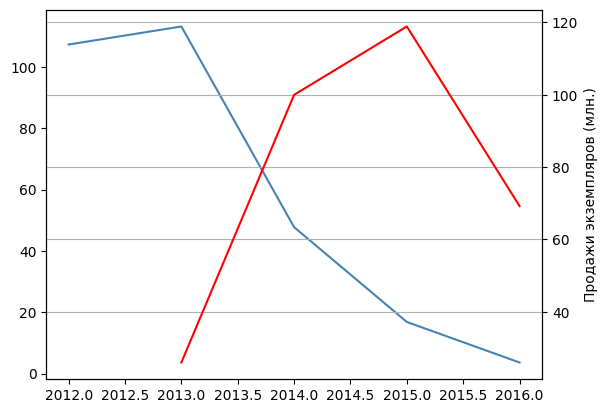

In [60]:
fig, ax = plt.subplots()

ps4 = popular_platforms.loc[popular_platforms['platform'] == 'PS4'].groupby('year_of_release').agg({'total_sales':'sum'})
x_one = popular_platforms.loc[popular_platforms['platform'] == 'XOne'].groupby('year_of_release').agg({'total_sales':'sum'})
ps3 = popular_platforms.loc[popular_platforms['platform'] == 'PS3'].groupby('year_of_release').agg({'total_sales':'sum'})
x360 = popular_platforms.loc[popular_platforms['platform'] == 'X360'].groupby('year_of_release').agg({'total_sales':'sum'})

ax.plot(ps3.total_sales, color='steelblue')
ax2 = ax.twinx()
ax2.plot(ps4, color='red')

plt.grid()
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Видно, что не смотря на небольшую разницу по суммарным продажам, PS3 начала терять в популярности еще с 2013 года, в то время как PS4 набирала обороты. Однако к 2016 году обе консоли подошли на спаде популярности

Сравним между собой PS4 и XOne - консоли одного поколения

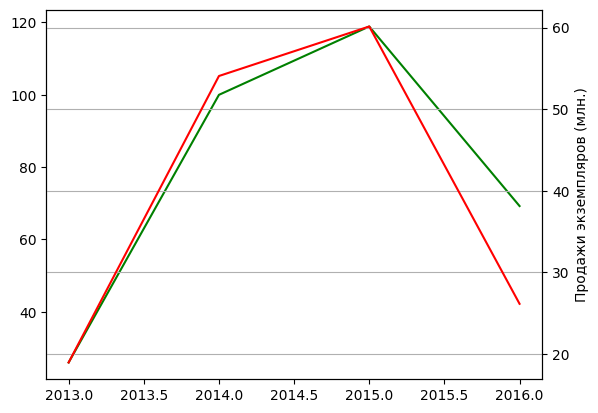

In [61]:
fig, ax = plt.subplots()
ax.plot(ps4.total_sales,color='green')
ax2 = ax.twinx()
ax2.plot(x_one.total_sales,color='red')
plt.xlabel('Год реализации')
plt.ylabel('Продажи экземпляров (млн.)')
plt.grid()
plt.show()

Их графики очень похожи по форме. Из них можно понять, что до 2014 года XboxOne был популярнее, чем PS4, но с 2015 года ситуация поменялась. В 2016 году на PlayStation4 было продано на 10 млн игр больше

Сравним две популярные портативные консоли 3DS и WiiU

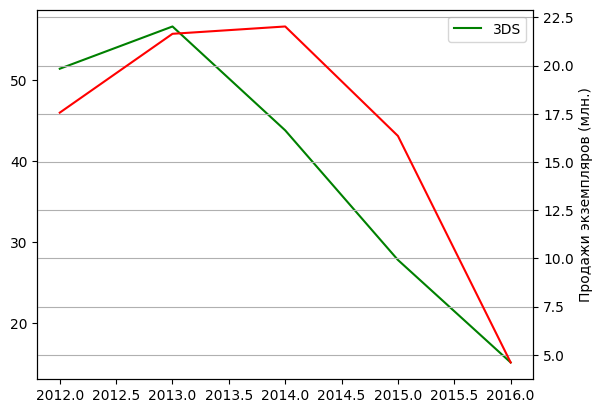

In [62]:
fig, ax = plt.subplots()
ds3 = popular_platforms.loc[popular_platforms['platform'] == '3DS'].groupby('year_of_release').agg({'total_sales':'sum'})
wiiu = popular_platforms.loc[popular_platforms['platform'] == 'WiiU'].groupby('year_of_release').agg({'total_sales':'sum'})

ax.plot(ds3.total_sales,color='green', label='3DS')

ax2 = ax.twinx()
ax2.plot(wiiu.total_sales,color='red', label='WiiU')
ax.legend()
plt.ylabel('Продажи экземпляров (млн.)')
plt.xlabel('Год выпуска (млн.)')
plt.grid()
plt.show()

к 2013 году на приставку WiiU стали продавать больше игр, чем на другую консоль этого же производителя 3DS. К 2016 году популярность обоих приставок сильно упала - меньше 4млн продаж в год. 

Построим график продаж игр на PC

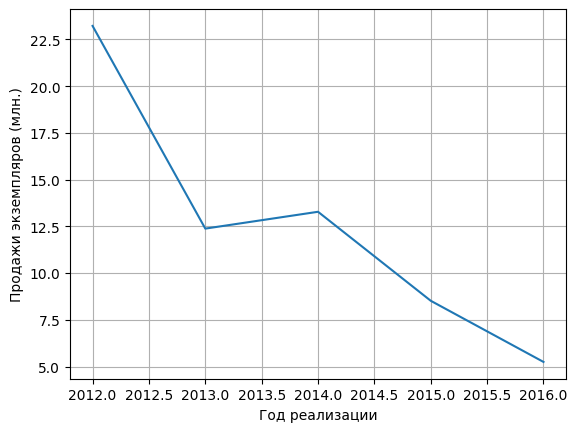

In [63]:
fig, ax = plt.subplots()
pc = popular_platforms.loc[popular_platforms['platform'] == 'PC'].groupby('year_of_release').agg({'total_sales':'sum'})
ax.plot(pc)
plt.xlabel('Год реализации')
plt.ylabel('Продажи экземпляров (млн.)')
plt.grid()
plt.show()

Популярность компьютерных игр стремительно падала весь выбранный период времени, к 2016 году продавали меньше 5 млн игр в год

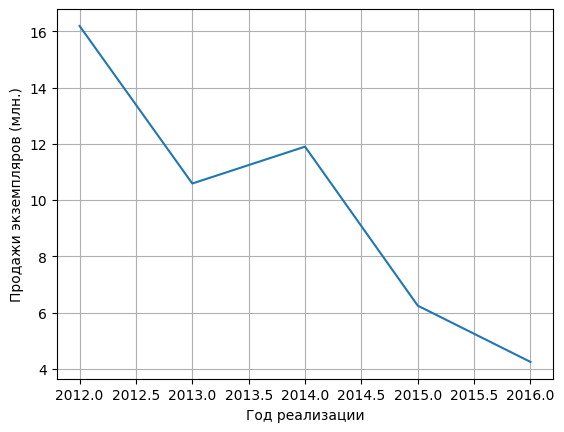

In [64]:
fig, ax = plt.subplots()
psv = popular_platforms.loc[popular_platforms['platform'] == 'PSV'].groupby('year_of_release').agg({'total_sales':'sum'})
plt.xlabel('Год реализации')
plt.ylabel('Продажи экземпляров (млн.)')
plt.grid()
ax.plot(psv);

#### Посмотрим на разброс продаж по разным консолям с помощью графика "ящик с усами"

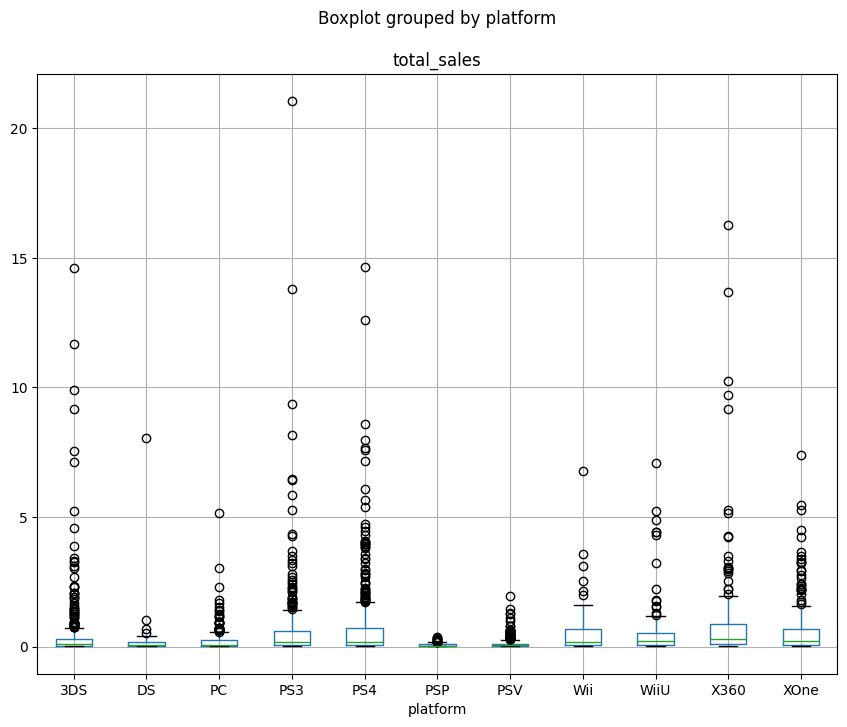

In [65]:
popular_platforms.boxplot(column='total_sales', by='platform', figsize=(10,8));

На графике видно распределение продаж игр на популярных платформах за последние 5 лет. У платформ 3DS, PS3, PS4, Wii, X360, XOne похожие по длине ящики - значит, их ежегодные продажи были примерно одинаково разбросаны, то есть давали стабильные продажи. У приставки PS3 самые сильные выбросы, наверное на нее выходило много игр-бестселлеров. У PS4, X360 тоже есть такие игры.
Чтобы внимательнее изучить медианы продаж, построим еще один график, где их будет лучше видно

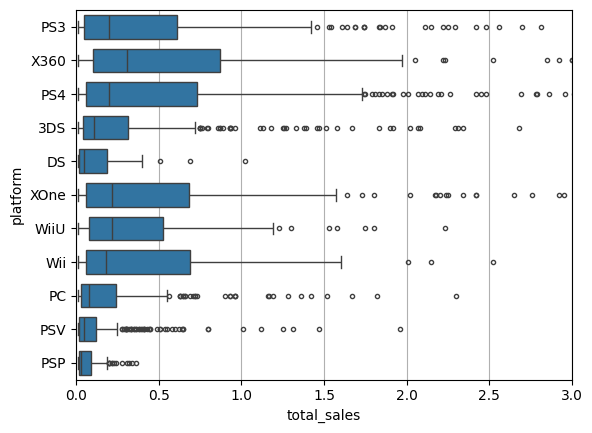

In [66]:
fig, ax = plt.subplots()
plt.xlim(0,3) 
plt.grid()
sns.boxplot(y=popular_platforms['platform'], x=popular_platforms['total_sales'], width=0.7,fliersize=3 )
plt.show()

Медианы у PS3 и X60 примерно равны, так же как у PS4 и XOne, вторые чуть ниже первых. Медиана WiiU выше медианы 3DS,а Wii еще выше. PC, PSV, DS и PSP имеют самые низкие медианы продаж. 

#### Посмотрим на влияние отзывов пользователей на продажи игр

In [67]:
# сперва проверим корреляцию между пользовательским рейтингом и глобальными продажам
popular_platforms.loc[popular_platforms['platform']=='PS3']['user_score'].corr(popular_platforms['total_sales'])

np.float64(-0.005143522887113802)

Корреляции между этими величинами почти нет

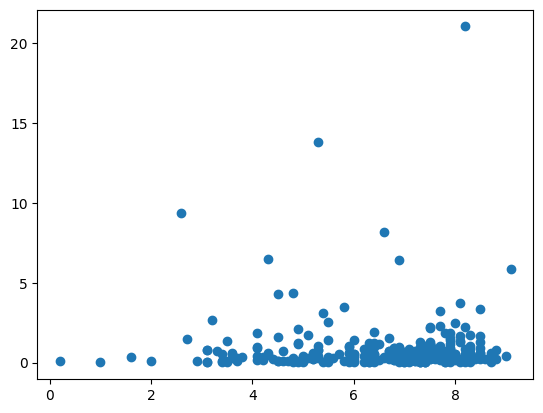

In [68]:
ps3 = popular_platforms.loc[popular_platforms['platform']=='PS3']
plt.scatter(x='user_score', y='total_sales', data=ps3);

In [69]:
popular_platforms.loc[popular_platforms['platform']=='PS4']['user_score'].corr(popular_platforms['total_sales'])

np.float64(-0.031957110204556466)

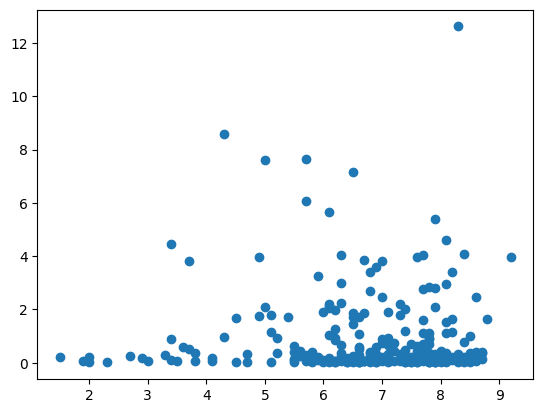

In [70]:
ps4 = popular_platforms.loc[popular_platforms['platform']=='PS4']
plt.scatter(x='user_score', y='total_sales', data=ps4);

In [71]:
popular_platforms.loc[popular_platforms['platform']=='XOne']['user_score'].corr(popular_platforms['total_sales'])

np.float64(-0.06892505328279419)

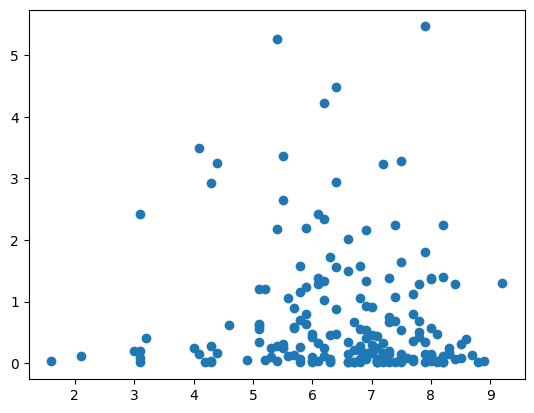

In [72]:
x_one = popular_platforms.loc[popular_platforms['platform']=='XOne']
plt.scatter(x='user_score', y='total_sales', data=x_one );

In [73]:
popular_platforms.loc[popular_platforms['platform']=='X360']['user_score'].corr(popular_platforms['total_sales'])

np.float64(0.00616397864621335)

In [74]:
popular_platforms.loc[popular_platforms['platform']=='WiiU']['user_score'].corr(popular_platforms['total_sales'])

np.float64(0.40021902021486155)

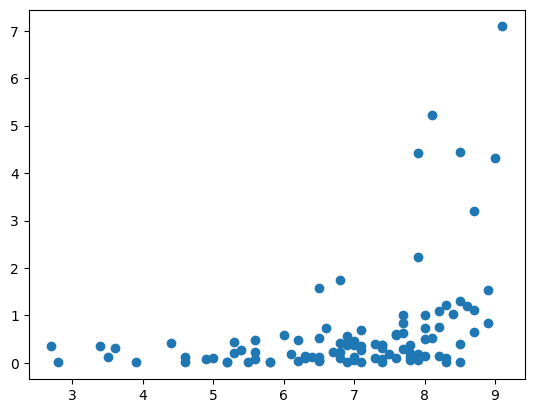

In [75]:
WiiU = popular_platforms.loc[popular_platforms['platform']=='WiiU']
plt.scatter(x='user_score', y='total_sales', data=WiiU);

И по значениям и по графикам видно, что корреляция между оценкой пользователей и продажей игр очень слабая у всех консолей, хотя у WiiU она чуть выше остальных

#### Теперь посмотрим на влияние отзывов критиков

In [76]:
popular_platforms.loc[popular_platforms['platform']=='PS4']['critic_score'].corr(popular_platforms['total_sales'])

np.float64(0.4065679020617815)

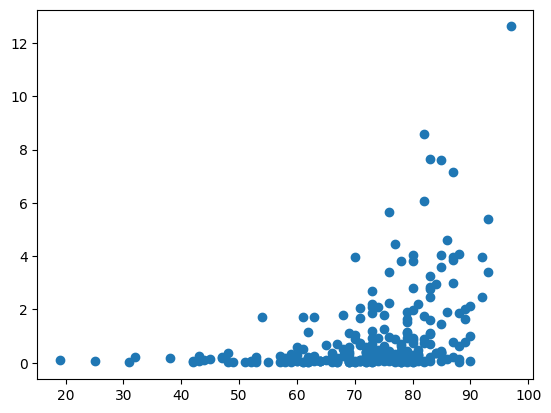

In [77]:
plt.scatter(x='critic_score', y='total_sales', data=ps4);

In [78]:
popular_platforms.loc[popular_platforms['platform']=='PS3']['critic_score'].corr(popular_platforms['total_sales'])

np.float64(0.3314972592629591)

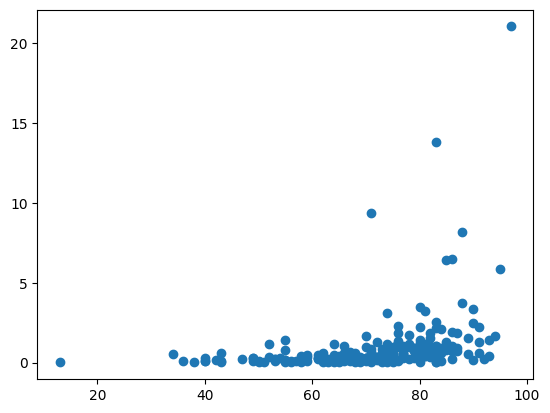

In [79]:
plt.scatter(x='critic_score', y='total_sales', data=ps3);

In [80]:
popular_platforms.loc[popular_platforms['platform']=='XOne']['critic_score'].corr(popular_platforms['total_sales'])

np.float64(0.4169983280084016)

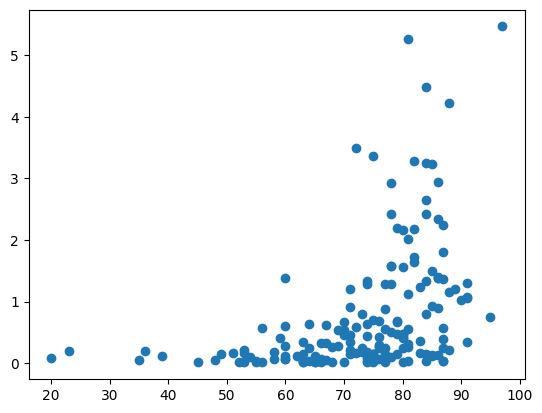

In [81]:
plt.scatter(x='critic_score', y='total_sales', data=x_one);

In [82]:
popular_platforms.loc[popular_platforms['platform']=='X360']['critic_score'].corr(popular_platforms['total_sales'])

np.float64(0.36057348885073365)

In [83]:
popular_platforms.loc[popular_platforms['platform']=='WiiU']['critic_score'].corr(popular_platforms['total_sales'])

np.float64(0.3483797601201749)

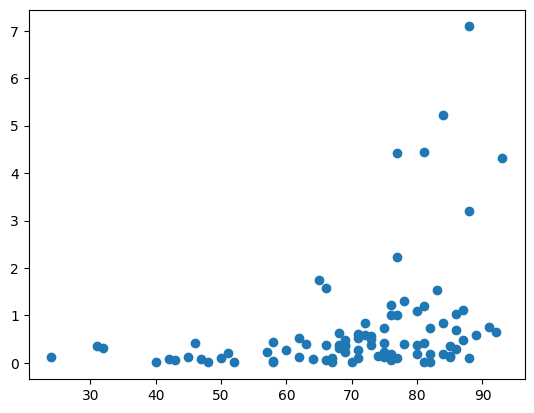

In [84]:
plt.scatter(x='critic_score', y='total_sales', data=WiiU); 

Вероятно отзывам критиков следует доверять чуть-чуть больше, ведь значения корреляции здесь выше. Графики тоже это подтверждают. Однако, корреляция все равна не такая большая, чтобы делать окончательный выводы

#### Посомтрим на общее распределение игр по жанрам

In [85]:
popular_platforms.pivot_table(index='genre', aggfunc={'total_sales':['sum','mean','median'],'name':'count'})\
.sort_values(by=[('name','count'),('total_sales','sum')],ascending=False)

name total_sales               
             count        mean median     sum
genre                                        
Action        1031    0.427856  0.120  441.12
Role-Playing   370    0.521081  0.140  192.80
Adventure      302    0.097450  0.030   29.43
Sports         268    0.675634  0.240  181.07
Shooter        235    1.296723  0.440  304.73
Misc           192    0.442917  0.120   85.04
Racing         115    0.465217  0.140   53.50
Fighting       109    0.408165  0.130   44.49
Platform        85    0.717647  0.210   61.00
Simulation      80    0.439000  0.120   35.12
Strategy        71    0.187887  0.080   13.34
Puzzle          28    0.174643  0.045    4.89

Больше всего в датасете педставлено игр жанра экшн: почти в 2 раза больше, чем игр следующего по популярности жанра. Их суммарные продажи велики, однако если посмотреть на медиану, то окажется, что значительное число продаж приходится на несколько игр, в то время как большинство из них продавалось хуже - всего около 200 тыс.шт. в год. <br>

Спортивные игры продаются гораздо лучше экшенов, несмотря на то что их меньше. Медиана и среднее значение продаж в год так же велики. <br> 

За ними идут шутеры, по количеству выпущенных игр они замыкают тройку лидеров, однако их суммарные продажи почти на 100 млн превысили продажи спортивных игр, и в среднем они продаются значительно лучше двух своих конкурентов. Самая большая медиана продаж именно у шутеров - следует обратить на это внимание. <br> 

Ролевых игр в датасете почти так же много, как и шутеров, но их суммарные продажи принесли более чем в 2 раза меньше денег.

### Составляем портрет пользователя

#### Самые популярные платформы

In [86]:
na_pivot = popular_platforms.pivot_table(index='platform',values='na_sales',aggfunc='sum')
na_total = popular_platforms['na_sales'].sum()
na_pivot['доля'] = round((na_pivot['na_sales']/na_total),2)
na_pivot.sort_values(by='na_sales',ascending=False).head(5)

,na_sales,доля
platform,,
X360,140.05,0.24
PS4,108.74,0.18
PS3,103.38,0.17
XOne,93.12,0.16
3DS,55.31,0.09


TOP-5 популярных консолей в Северной Америке: x360, ps4, ps3, XOne, 3DS. На первом месте приставка xbox360 американской компании Microsoft, японские приставки от компании SONY занимают 2 и 3 места

In [87]:
eu_pivot = popular_platforms.pivot_table(index='platform',values='eu_sales',aggfunc='sum')
eu_total = popular_platforms['eu_sales'].sum()
eu_pivot['доля'] = round((eu_pivot['eu_sales']/eu_total),2)
eu_pivot.sort_values(by='eu_sales',ascending=False).head(5)

,eu_sales,доля
platform,,
PS4,141.09,0.28
PS3,106.86,0.21
X360,74.52,0.15
XOne,51.59,0.10
3DS,42.64,0.08


В Европе ситуация противоположная: консоли PlayStation более популярны, чем XBOX и занимают первые два места. Xbox старого и нового поколения сразу за ними, затем портативная Nintendo 3DS. 

In [88]:
jp_pivot = popular_platforms.pivot_table(index='platform',values='jp_sales',aggfunc='sum')
jp_total = popular_platforms['jp_sales'].sum()
jp_pivot['доля'] = round((jp_pivot['jp_sales']/jp_total),2)
jp_pivot.sort_values(by='jp_sales',ascending=False).head(5)

,jp_sales,доля
platform,,
3DS,87.79,0.46
PS3,35.29,0.18
PSV,21.04,0.11
PS4,15.96,0.08
WiiU,13.01,0.07


Среди лидеров японского рынка платформы 3DS, PS3, PSV, PS4, WiiU. В отличие от других регионов здесь более популярны портативные консоли. Все приставки являются продуктами японских компаний Nintendo и Sony. Так же в этот топ попали приставки PSV и WiiU, которые так популярны только в этом регионе. Видно, что почти половина продаж игр в Японии приходится на консоль 3DS, она безоговорочный лидер по этому региону, ни в одном другом нет такого перевеса в пользу какой-либо консоли.

#### Самые популярные жанры

In [89]:
na_pivot_genres = popular_platforms.pivot_table(index='genre',values='na_sales',aggfunc='sum')
na_total_genres = popular_platforms['na_sales'].sum()
na_pivot_genres['доля'] = round((na_pivot_genres['na_sales']/na_total_genres),2)
na_pivot_genres.sort_values(by='na_sales',ascending=False).head(5)

,na_sales,доля
genre,,
Action,177.84,0.30
Shooter,144.77,0.24
Sports,81.53,0.14
Role-Playing,64.00,0.11
Misc,38.19,0.06


С небольшим перевесом игры в жанре экшн лидируют на американском рынке, за ними шутеры. Спортивные, ролевые и так называемые Miscellaneous game - игры, не вошедшые в предыдущие жанры, замыкают ТОП-5 

In [90]:
eu_pivot_genres = popular_platforms.pivot_table(index='genre',values='eu_sales',aggfunc='sum')
eu_total_genres = popular_platforms['eu_sales'].sum()
eu_pivot_genres['доля'] = round((eu_pivot_genres['eu_sales']/eu_total_genres),2)
eu_pivot_genres.sort_values(by='eu_sales',ascending=False).head(5)

,eu_sales,доля
genre,,
Action,159.34,0.31
Shooter,113.47,0.22
Sports,69.09,0.14
Role-Playing,48.53,0.10
Racing,27.29,0.05


Похожая ситуация в Европейском регионе, экшены и шутеры на первых двух местах, за ними спортивные игры, их доли разделились почти так же. Единственное отличие - в этом регионе любят играть в гонки сильнее, чем в Америке

In [91]:
jp_pivot_genres = popular_platforms.pivot_table(index='genre',values='jp_sales',aggfunc='sum')
jp_total_genres = popular_platforms['jp_sales'].sum()
jp_pivot_genres['доля'] = round((jp_pivot_genres['jp_sales']/jp_total_genres),2)
jp_pivot_genres.sort_values(by='jp_sales',ascending=False).head(5)

,jp_sales,доля
genre,,
Role-Playing,65.44,0.34
Action,52.80,0.27
Misc,12.86,0.07
Simulation,10.41,0.05
Fighting,9.44,0.05


Японский регион снова не похож на остальные, здесь ролевые игры вытесняют экшн с первого места. Так же японцы любят игры симмуляции и меньше играют в шутеры, нежели в Европе или в Америке

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе

In [92]:
popular_platforms.groupby('rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)

,na_sales
rating,
M,231.57
E,114.37
Unknown,103.31
E10+,75.70
T,66.02


In [93]:
popular_platforms.groupby('rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)

,eu_sales
rating,
M,193.96
E,113.03
Unknown,91.50
E10+,55.37
T,52.96


У Европы и Северной Америки похожая ситуация - больше всего покупают игры категории М (для лиц старше 17). Затем - Е (для всех возрастов). 

In [94]:
popular_platforms.groupby('rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)

,jp_sales
rating,
Unknown,108.84
E,28.33
T,26.02
M,21.20
E10+,8.19


В Японии всё по-другому. Почти одинаково популярны игры для всех возрастов и для лиц старше 13. 

Игры, рейтинг которых по каким-то причинам неизвестен, занимают большую долю от общего числа. В Японии такие игры занимают первое место по популярности с большим отрывом от других. Что ж, Япония - страна загадка. За такими играми могут скрываться малоизвестные игры или японские игры, в то время как ESRB присваивает рейтинг только в США и Канаде. 

### Проверка гипотез 

H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <br>
H1 - Средние пользовательские рейтинги платформ Xbox One и PC разные

In [95]:
# для проверки гипотез нужно исключить пропуски в user_score
popular_platforms_without_nan = popular_platforms.copy()
popular_platforms_without_nan = popular_platforms_without_nan.dropna(subset=['user_score'])

In [96]:
x_one_ratings = popular_platforms_without_nan.loc[popular_platforms_without_nan['platform']=='XOne','user_score']
print('Средний рейтинг среди XboxOne:',x_one_ratings.mean())
pc_ratings = popular_platforms_without_nan.loc[popular_platforms['platform']=='PC','user_score']
print('Средний рейтинг среди PC:', pc_ratings.mean())

# будем сопоставлять среднее двух генеральных совокупностей с помощью метода ttest_ind
results = st.ttest_ind(
x_one_ratings,
pc_ratings)

# уровень значимости 5%
alpha = 0.05
alpha1 = 0.01

Средний рейтинг среди XboxOne: 6.521428571428572
Средний рейтинг среди PC: 6.4286407766990274


In [97]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


In [98]:
if results.pvalue < alpha1:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC разные")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Т.к. полученный pvalue = вероятность получить наблюдаемый результат, при условии что нулевая гипотеза верна, оказался больше, чем заданные нами уровни значимости в 5% и даже в 1%, то мы не отвергаем нулевую гипотезу. 

H0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые <br>
H1 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные <br>

In [99]:
action_ratings = popular_platforms_without_nan.loc[popular_platforms['genre']=='Action','user_score']
sports_ratings = popular_platforms_without_nan.loc[popular_platforms['genre']=='Sports','user_score']

results = st.ttest_ind(
action_ratings,
sports_ratings)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

Отвергаем нулевую гипотезу.


In [100]:
print('Средние пользовательские рейтинги экшенов ',action_ratings.mean())
print('Средние пользовательские рейтинги спортивных игр ',sports_ratings.mean())

Средние пользовательские рейтинги экшенов  6.825047801147227
Средние пользовательские рейтинги спортивных игр  5.455897435897437


Т.к. полученный pvalue = вероятность получить наблюдаемый результат, при условии что нулевая гипотеза верна, оказался меньше, чем заданный нами урвоень значимости в 5%, то мы отвергли нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports разные

Больше всего в датасете педставлено игр жанра экшн: почти в 2 раза больше, чем игр следующего по популярности жанра спортивных. Их суммарные продажи велики, однако если посмотреть на медиану, то окажется, что значительное число продаж приходится на несколько игр, в то время как большинство из них продавалось хуже - всего около 200 тыс.шт. в год. Шутеры, по количеству выпущенных игр они замыкают тройку лидеров, однако в среднем они продаются значительно лучше двух своих конкурентов. Самая большая медиана продаж именно у шутеров - следует обратить на это внимание. <br>

Консоли PS4 и XOne - лидеры по продажам в 2016 году, на них стоит делать упор. Несмотря на то, что цифры у PS3 и X360 велики, эти консоли теряют свою популярность.  <br>

Оценки пользоателей не влияют на продаваемость игр, а к оценкам критиков прислушиваются чуть больше. <br>

Если мы хотим популярности в Японском регионе, то смотреть нужно в сторону ролевых игр, а так же игр для портативных консолей,например WiiU, которые подойдут всем возрастам. Так же стоит учесть, что в Японии предпочитают игры, выпущенные японскими разработчиками  <br>